In [2]:
import csv
import matplotlib.pyplot as plt
import cv2
import numpy as np

lines = []
with open('./driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
print(len(lines))       


10653


True

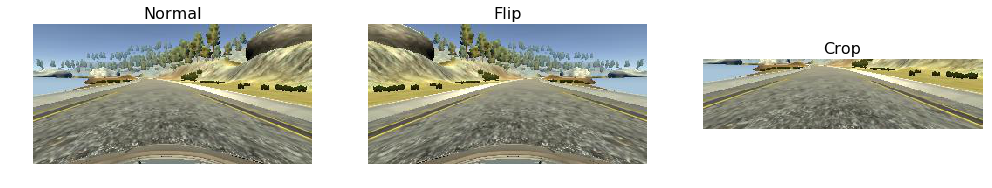

In [11]:
file_name = lines[0][0]
fig, axs = plt.subplots(1,3, figsize=(17, 10))
axs = axs.ravel()

out_dir = './examples/'


image = cv2.imread(file_name)
flip_image = cv2.flip(image, 1)
crop_image = image[55:135,:,:]
#image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

axs[0].axis('off')
axs[0].set_title('Normal', fontsize=16)
axs[0].imshow(image[...,::-1])

axs[1].axis('off')
axs[1].set_title('Flip', fontsize=16)
axs[1].imshow(flip_image[...,::-1])

axs[2].axis('off')
axs[2].set_title('Crop', fontsize=16)
axs[2].imshow(crop_image[...,::-1])

out_name = out_dir+'normal_image.jpg'
cv2.imwrite(out_name, image)

out_name = out_dir+'flip_image.jpg'
cv2.imwrite(out_name, flip_image)

out_name = out_dir+'crop_image.jpg'
cv2.imwrite(out_name, crop_image)





In [15]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Convolution2D, ELU, Flatten, Dropout, Dense, Lambda, MaxPooling2D, Cropping2D
from keras.preprocessing.image import img_to_array, load_img
import cv2
import sklearn

def preprocess_image(image):
    image = image[55:135, :, :]
    
    #Normalize image
    image = image/255.0 - 0.5
    return image

def generator(samples, batch_size=32):
    num_samples = len(samples)
    
    while 1: # Loop forever so the generator never terminates
        #shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                #name = './IMG/'+batch_sample[0].split('/')[-1]
                angle = float(batch_sample[3])
                name= batch_sample[0]
                camera = np.random.choice(['center', 'left', 'right', 'flip'])
                #print(camera)
                
                if camera == 'left':
                    angle += 0.20
                    name = batch_sample[1]
                elif camera == 'right':
                    angle -= 0.20
                    name= batch_sample[2]
                elif camera == 'flip' :   
                    angle = -1*angle
                    
                image = cv2.imread(name)
                if camera == 'flip' :
                    image = cv2.flip(image,1)
                
                #print(camera, name)
                images.append(image)
                angles.append(angle)

            
            # trim image to only see section with road
            X_batch = np.array(images)
            y_batch = np.array(angles)
            yield sklearn.utils.shuffle(X_batch, y_batch)

def get_lenet_model():
    model = Sequential()

    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160, 320, 3), output_shape=(160, 320, 3)))
    #model.add(Lambda(preprocess_image, input_shape=(160, 320, 3), output_shape=(80, 320, 3)))

    model.add(Convolution2D(32,5,5, subsample=(2,2), activation='relu', input_shape=(160, 320, 3)))
    model.add(Convolution2D(64,5,5, subsample=(2,2),  activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
   

    model.compile(optimizer="adam", loss="mse")

    return model
            
def get_model():
    model = Sequential()

    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160, 320, 3), output_shape=(160, 320, 3)))

    model.add(Cropping2D(cropping=((70,25),(0,0))))
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation="relu"))
              
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation="relu"))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation="relu"))
    model.add(Convolution2D(64,3,3, activation="relu"))
    model.add(Convolution2D(64,3,3, activation="relu"))
    model.add(Flatten())
    # Finally a single output, since this is a regression problem
    model.add(Dense(100))
    model.add(Dense(50))  
    model.add(Dense(10))  
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    return model


In [16]:
BATCH_SIZE = 32


lines = []
with open('./driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
print(len(lines))      

used_lines = lines[0:1800] + lines[9200:]
train_samples, validation_samples = train_test_split(used_lines, test_size=0.2)


train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)

model = get_lenet_model()

model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator, 
                    nb_val_samples=len(validation_samples), nb_epoch=2)

print("Saving model weights and configuration file.")

model.save('model_lenet.h5')  # always save your weights after training or during training

10653
Epoch 1/2
2602/2602 [==============================] - 150s - loss: 0.1438 - val_loss: 0.0307
Epoch 2/2
2602/2602 [==============================] - 149s - loss: 0.0390 - val_loss: 0.0241
Saving model weights and configuration file.


In [46]:
model.save('model_lenet.h5')